# WSL SDK Jupyter Python Sample Notebook

This notebook contains example code that demonstrates how to dynamically create an Alpine Linux distribution using the WSL SDK project and create/manage an integrated test environment in an API way.

To run this sample notebook, you need to install the pywin32 at https://github.com/mhammond/pywin32/releases.

Then, get the latest version of the source code from https://github.com/wslhub/wsl-sdk-com and register your Out-of-Process COM server with the 64-bit version `regasm.exe` utility.

## Creating WSL SDK Object

Use `win32com.client.Dispatch` to create WSL SDK object.

In [1]:
import win32com.client

obj = win32com.client.Dispatch("WslSdk.WslService")
print("A WslSdk.WslService object was created.")

A WslSdk.WslService object was created.


When creating the WSL SDK object, the `WslSdk.exe` process automatically started, and a new icon is added to the tray icon on the taskbar as follows.

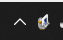

## Retrieve a list of installed distributions

You can call the `GetDistroNames` function to retrieve the names of the WSL distributions currently installed on the system.

In [3]:
# Get installed distro list
list = obj.GetDistroNames()
print(list)

('Ubuntu-20.04',)


## Create a random distribution name

As a necessary function to build an automated, integrated test environment, it provides an API that automatically names English words that are easy for humans to remember, but that is unlikely to overlap in the system. I excerpted the code for this method from [here] (https://github.com/moby/docker/blob/master/pkg/namesgenerator/names-generator.go).

In [4]:
# Generate random name
random_name = obj.GenerateRandomName(False)
print(random_name)

awesome_wu


## Get Alpine Linux Root File System

Even if you don't have a root filesystem designed for WSL, you can import and use the root filesystem into WSL as long as your CPU architecture matches.

In [5]:
# Download the Alpine Linux RootFS Image
import tempfile
import requests
import os

target_url = "https://dl-cdn.alpinelinux.org/alpine/v3.14/releases/x86_64/alpine-minirootfs-3.14.0-x86_64.tar.gz"
rootfs_filepath = os.path.join(tempfile.gettempdir(), "alpine.tar.gz")
install_path = os.path.join("/Distro", random_name)

if not os.path.exists(install_path):
    os.mkdir(install_path)


print("Downloading distro root file system image...")
print(" - URL: %s" % target_url)
print(" - Download Path: %s" % rootfs_filepath)
print(" - Install Directory: %s" % install_path)

r = requests.get(target_url, allow_redirects=True)
open(rootfs_filepath, 'wb').write(r.content)

 - URL: https://dl-cdn.alpinelinux.org/alpine/v3.14/releases/x86_64/alpine-minirootfs-3.14.0-x86_64.tar.gz
 - Download Path: C:\Users\rkttu\AppData\Local\Temp\alpine.tar.gz
 - Install Directory: /Distro\awesome_wu


2727495

## Installing the WSL distribution

You can install a WSL distribution like this:

In [6]:
# Register distro
print("Installing distro %s..." % random_name)
obj.RegisterDistro(random_name, rootfs_filepath, install_path)

# Distro register check
result = obj.IsDistroRegistered(random_name)
print("Distro %s registered? %s" % (random_name, result))

Installing distro awesome_wu...
Distro awesome_wu registered? True


## Querying WSL Distribution Properties

You can retrieve the result in the form of an object by inquiring about the properties of the WSL distribution.

In [10]:
# Metadata query
o = obj.QueryDistroInfo(random_name)
print(" - Distro ID: %s" % o.DistroId)
print(" - Distro Name: %s" % o.DistroName)
print(" - Environment Variables: %s" % o.DefaultEnvironmentVariables)
print(" - Default Uid: %s" % o.DefaultUid)
print(" - Flags: %s" % o.DistroFlags)
print(" - Win32 Interop Enabled: %s" % o.EnableInterop)
print(" - Drive Mouting Enabled: %s" % o.EnableDriveMounting)
print(" - NT Path Append Enabled: %s" % o.AppendNtPath)
print(" - WSL Version: %s" % o.WslVersion)

 - Distro ID: bd6760cb-5519-462e-8374-9c3fa05da3c8
 - Distro Name: awesome_wu
 - Environment Variables: <PyIUnknown at 0x00000194429CBA10 with obj at 0x0000019442738A80>
 - Default Uid: 0
 - Flags: 15
 - Win32 Interop Enabled: True
 - Drive Mouting Enabled: True
 - NT Path Append Enabled: True
 - WSL Version: 2


## Running the command

You can execute a command of a specific WSL distribution in an API way and get the result as a string. Internally, it uses Win32 Anonymous Pipe communication to send and receive data.

In [11]:
# Run WSL Command
result = obj.RunWslCommand(o.DistroName, "apk add vim")
print(result)

fetch https://dl-cdn.alpinelinux.org/alpine/v3.14/main/x86_64/APKINDEX.tar.gz
fetch https://dl-cdn.alpinelinux.org/alpine/v3.14/community/x86_64/APKINDEX.tar.gz
(1/5) Installing xxd (8.2.2956-r0)
(2/5) Installing lua5.3-libs (5.3.6-r0)
(3/5) Installing ncurses-terminfo-base (6.2_p20210612-r0)
(4/5) Installing ncurses-libs (6.2_p20210612-r0)
(5/5) Installing vim (8.2.2956-r0)
Executing busybox-1.33.1-r2.trigger
OK: 25 MiB in 19 packages



## Automatic creation of Distro Launcher

WslRegisterDistribution API automatically creates a Linux file system for WSL1 or WSL2 based on the EXE file path that calls the API unconditionally. The WSL SDK automatically creates a simple EXE file dedicated only to WSL registration to overcome this problem. At the same time, it starts a launcher that allows you to directly enter the distribution by simply calling the EXE file later.

In [12]:
# Revealing launcher executable
import subprocess

explorer_path = os.path.join(os.getenv('WINDIR'), 'explorer.exe')
launcher_path = os.path.join(install_path, "%s.exe" % o.DistroName)
subprocess.run([explorer_path, '/select,', os.path.normpath(launcher_path)])

CompletedProcess(args=['C:\\Windows\\explorer.exe', '/select,', '\\Distro\\awesome_wu\\awesome_wu.exe'], returncode=1)

In the folder window that opens after running this sample code, double-click the distribution launcher executable file and check if the VIM editor exists; you can run the VIM editor as shown in the picture below.

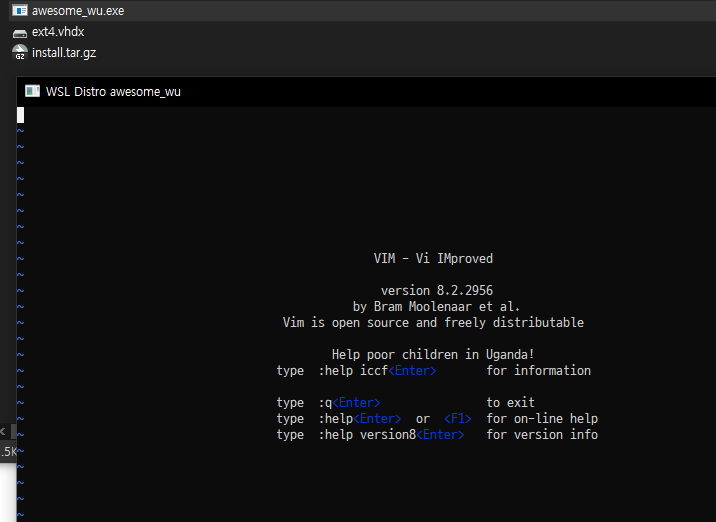

## Unregister your WSL distribution

You can unregister a registered WSL distribution as shown below.

In [13]:
# Unregister distro
print("Uninstalling distro %s..." % random_name)
obj.UnregisterDistro(random_name)

# Distro register check
result = obj.IsDistroRegistered(random_name)
print("Distro %s registered? %s" % (random_name, result))

Uninstalling distro awesome_wu...
Distro awesome_wu registered? False
